# Building Classifiers for Predicting the KKBOX Churn Rate

## 1. Define the Business Need

Mission: Predict whether a user will churn after his/her subscription expires. Specifically, we want to forecast if a user make a new service subscription transaction within 30 days after the current membership expiration date.

KKBOX offers subscription based music streaming service. When users signs up for our service, users can choose to either manual renew or auto-renew the service. Users can actively cancel their membership at any time.  

The churn/renewal definition can be tricky due to KKBox's subscription model. Since the majority of KKBox's subscription length is 30 days, a lot of users re-subscribe every month. The key fields to determine churn/renewal are transaction date, membership expiration date, and is_cancel. 

Note that the is_cancel field indicates whether a user actively cancels a subscription. Subscription cancellation does not imply the user has churned. A user may cancel service subscription due to change of service plans or other reasons. The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.

### Business Need: Predict whether a user will churn after his/her subscription expires. 


#### Target Variable: `is_churn`

`is_churn` = `1` means churn  
`is_churn` = `0` means renewal

#### Features:  
(1) `msno`: user_id   
(2) `city`: dummary variable with values ranging from `1` to `22`   
(3) `bd` : age ranging from `-2828` to `1049`  
(4) `registered_via`: registration method  
(5) `registration_init_time`: format `%Y%m%d`  
(6) `payment_method_id`: payment method  
(7) `payment_plan_days`: length of membership plan in days  
(8) `plan_list_price`: in New Taiwan Dollar (NTD)    
(9) `actual_amount_paid`: in New Taiwan Dollar (NTD)    
(10) `is_auto_renew`: `0` means Yes; `1` means No  
(11) `transaction_date`: format `%Y%m%d`  
(12) `membership_expire_date`: format `%Y%m%d`  
(13) `is_cancel`: whether or not the user canceled the membership in this transaction  
(14) `Date`: format `%Y%m%d`  
(15) `num_25`: # of songs played less than 25% of the song length  
(16) `num_50`: # of songs played between 25% to 50% of the song length  
(17) `num_75`: # of songs played between 50% to 75% of of the song length  
(18) `num_985`: # of songs played between 75% to 98.5% of the song length  
(19) `num_100`: # of songs played over 98.5% of the song length  
(20) `num_unq`: # of unique songs played  
(21) `total_secs`: total seconds played  
(22) `date`

## 2. Explore the Data

In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
sns.set()

###  2.1 Import and Merge Data

In [301]:
train = pd.DataFrame(pd.read_csv('train_v2.csv'))

In [302]:
members = pd.DataFrame(pd.read_csv('members_v3.csv'))
transactions = pd.DataFrame(pd.read_csv('transactions_v2.csv'))
user_logs = pd.DataFrame(pd.read_csv('user_logs_v2.csv'))

In [303]:
df_1 = pd.merge(left=train, right=members, how='left', on=['msno'])
df_2 = pd.merge(left=df_1, right=transactions, how='left', on=['msno'])
df_final = pd.merge(left=df_2, right=user_logs, how='left', on=['msno'])

In [304]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16887877 entries, 0 to 16887876
Data columns (total 23 columns):
msno                      object
is_churn                  int64
city                      float64
bd                        float64
gender                    object
registered_via            float64
registration_init_time    float64
payment_method_id         float64
payment_plan_days         float64
plan_list_price           float64
actual_amount_paid        float64
is_auto_renew             float64
transaction_date          float64
membership_expire_date    float64
is_cancel                 float64
date                      float64
num_25                    float64
num_50                    float64
num_75                    float64
num_985                   float64
num_100                   float64
num_unq                   float64
total_secs                float64
dtypes: float64(20), int64(1), object(2)
memory usage: 3.0+ GB


### 2.2 Random Sampling 

`16887877` entries in total (> ten millions!)

Since the full dataset is incredibly large, I just randomly selected 1 hundred thousands rows for EDA and modeling in order to increase efficiency.

In [305]:
KK = df_final.sample(n=100000)

In [306]:
KK.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 209797 to 10883204
Data columns (total 23 columns):
msno                      100000 non-null object
is_churn                  100000 non-null int64
city                      99302 non-null float64
bd                        99302 non-null float64
gender                    53283 non-null object
registered_via            99302 non-null float64
registration_init_time    99302 non-null float64
payment_method_id         97987 non-null float64
payment_plan_days         97987 non-null float64
plan_list_price           97987 non-null float64
actual_amount_paid        97987 non-null float64
is_auto_renew             97987 non-null float64
transaction_date          97987 non-null float64
membership_expire_date    97987 non-null float64
is_cancel                 97987 non-null float64
date                      98512 non-null float64
num_25                    98512 non-null float64
num_50                    98512 non-null float64
nu

In [307]:
KK.sample(10)

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,...,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
5821224,LDVAOb1m9obXwEdlhL/L0QYUKIL2daqDCgy5GqxUDFM=,0,4.0,22.0,female,9.0,20110830.0,39.0,30.0,149.0,...,20170521.0,0.0,20170310.0,0.0,0.0,0.0,1.0,143.0,99.0,31293.141
12175794,BtCZBtl4lHCZRw6lGRsrOPJnJ0wFGuaeEkbFlYpkWLU=,0,1.0,0.0,NaN,7.0,20160731.0,41.0,30.0,99.0,...,20170430.0,0.0,20170301.0,4.0,0.0,0.0,1.0,6.0,3.0,1970.554
3897793,8hxOGb7gcaB15JhiEWDmVIe/CWOuQA9EheUEBIaMsdQ=,0,22.0,36.0,female,9.0,20080810.0,40.0,30.0,149.0,...,20170403.0,0.0,20170308.0,3.0,0.0,0.0,0.0,42.0,37.0,9852.018
12421674,5Q0kW3UvXuwmLVT9HBeDFm+fGgQc1RKjkCGIHM6I5NI=,0,5.0,23.0,female,9.0,20100811.0,36.0,30.0,180.0,...,20170423.0,0.0,20170301.0,1.0,2.0,0.0,2.0,33.0,36.0,8818.802
3996690,S/m+Np48bGua9OlBgfeUY5mGynfpJD0nGs0Byf04mDU=,0,5.0,0.0,NaN,3.0,20130106.0,36.0,30.0,180.0,...,20170410.0,0.0,20170302.0,45.0,2.0,1.0,4.0,18.0,33.0,7420.762
11026238,eJ+4fbb8UhoM7WgFx8e06BLDAYdf/irTup6gI5tXlcY=,0,1.0,0.0,NaN,7.0,20141201.0,41.0,30.0,129.0,...,20170407.0,0.0,20170323.0,6.0,1.0,2.0,2.0,25.0,26.0,7531.384
16041990,OnZJkszR4ABHlNJyi4cfTXqD1rqAyK2eDnnhrHlSWPQ=,0,4.0,0.0,NaN,9.0,20170124.0,37.0,30.0,149.0,...,20170426.0,0.0,20170329.0,0.0,0.0,0.0,1.0,4.0,5.0,1185.286
8750791,ESq47unOow5OdVNmM4OY0e5/9hsbg8+n8Z5eYCC676s=,0,6.0,24.0,female,3.0,20170107.0,29.0,30.0,180.0,...,20170425.0,0.0,20170313.0,1.0,0.0,0.0,0.0,15.0,4.0,3336.487
15939968,nZfAxljd39RQc7tmmzblHag4XB/uG69lLAW1XolPJq0=,0,5.0,24.0,male,3.0,20141205.0,37.0,30.0,149.0,...,20170425.0,0.0,20170319.0,0.0,0.0,0.0,0.0,6.0,6.0,1431.555
9341578,G6iZaROZYfFHuFqwgP7TNAFJCY+Mo7ZGDmtCvtehqZE=,0,1.0,0.0,NaN,7.0,20160229.0,41.0,30.0,99.0,...,20170430.0,0.0,20170303.0,7.0,2.0,2.0,1.0,28.0,24.0,7260.715


In [308]:
KK.to_csv('KK.csv')

## 3. Explanatory Data Analysis

In [584]:
df = pd.DataFrame(pd.read_csv('KK.csv'))

In [600]:
df.loc[df['msno'] == 'vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=']

,Unnamed: 0,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,...,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
5771,773413,vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=,1,6.0,23.0,male,4.0,20160229.0,38.0,10.0,...,20200518.0,0.0,20170318.0,7.0,3.0,1.0,2.0,104.0,107.0,28057.674
13546,773907,vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=,1,6.0,23.0,male,4.0,20160229.0,38.0,10.0,...,20190802.0,0.0,20170306.0,11.0,3.0,3.0,3.0,92.0,100.0,24287.727
16157,772390,vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=,1,6.0,23.0,male,4.0,20160229.0,38.0,10.0,...,20170524.0,0.0,20170318.0,7.0,3.0,1.0,2.0,104.0,107.0,28057.674
27179,771728,vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=,1,6.0,23.0,male,4.0,20160229.0,38.0,10.0,...,20181215.0,0.0,20170330.0,0.0,0.0,0.0,2.0,36.0,38.0,9442.268
29116,772891,vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=,1,6.0,23.0,male,4.0,20160229.0,38.0,10.0,...,20190124.0,0.0,20170313.0,5.0,1.0,1.0,0.0,95.0,90.0,24676.223
33624,774570,vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=,1,6.0,23.0,male,4.0,20160229.0,38.0,10.0,...,20200508.0,0.0,20170311.0,0.0,1.0,0.0,2.0,99.0,102.0,26686.105
42916,771264,vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=,1,6.0,23.0,male,4.0,20160229.0,38.0,10.0,...,20171230.0,0.0,20170310.0,1.0,0.0,0.0,0.0,104.0,105.0,23857.509
45650,771832,vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=,1,6.0,23.0,male,4.0,20160229.0,38.0,10.0,...,20181115.0,0.0,20170318.0,7.0,3.0,1.0,2.0,104.0,107.0,28057.674
46850,772587,vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=,1,6.0,23.0,male,4.0,20160229.0,38.0,10.0,...,20190703.0,0.0,20170328.0,5.0,1.0,0.0,1.0,89.0,81.0,24387.938
53643,774011,vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=,1,6.0,23.0,male,4.0,20160229.0,38.0,10.0,...,20180208.0,0.0,20170331.0,0.0,0.0,0.0,1.0,5.0,5.0,1246.947


In [4]:
df.head(5)

,Unnamed: 0,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,...,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,209797,VHgnL4m+p5P3RJ0ca/7ndoLU4BYLvPirvWRkPCyUAvU=,1,1.0,0.0,NaN,9.0,20120422.0,36.0,30.0,...,20170411.0,0.0,20170321.0,0.0,2.0,1.0,0.0,26.0,28.0,7598.271
1,12741714,VOQ/QOp/Vv53NpCsWbxHXDuoMaLEuJJSC+yjVFuqoWw=,0,1.0,0.0,NaN,7.0,20121223.0,41.0,30.0,...,20170405.0,0.0,20170308.0,8.0,6.0,4.0,9.0,2.0,20.0,3255.342
2,5643861,UVB0+2w0IfnJc8Y7v637Df6IvUtEPXlmt5O2TL9xXwE=,0,3.0,18.0,male,4.0,20161115.0,29.0,30.0,...,20170324.0,0.0,20170315.0,5.0,0.0,2.0,1.0,25.0,25.0,5904.042
3,11834678,7eF5+empHjU4YA7Pfp9YlEuf/hlmLHWAY0/6inI6MPo=,0,15.0,24.0,female,3.0,20121117.0,39.0,30.0,...,20170528.0,0.0,20170309.0,7.0,7.0,4.0,2.0,145.0,62.0,36813.632
4,6415447,K4Z5ua51A08yvmsXp3OnO9u30MPSIrs/fkhFKcxOdu0=,0,13.0,31.0,female,9.0,20080411.0,40.0,30.0,...,20170404.0,0.0,20170318.0,3.0,0.0,0.0,0.0,63.0,52.0,15097.984


In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
df.describe()

,is_churn,city,bd,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,...,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,100000.000000,99302.000000,99302.000000,99302.000000,9.930200e+04,97987.000000,97987.000000,97987.000000,97987.000000,97987.000000,...,9.798700e+04,97987.000000,9.851200e+04,98512.000000,98512.000000,98512.000000,98512.000000,98512.000000,98512.000000,98512.000000
mean,0.100910,6.935701,15.665123,6.874585,2.012926e+07,38.456795,35.135069,157.526529,156.944074,0.875555,...,2.017086e+07,0.023105,2.017032e+07,5.998457,1.462857,0.925715,1.071819,30.185145,28.740976,7882.880241
std,0.301211,6.638636,18.613675,2.076594,3.016795e+04,4.040186,38.129117,159.446312,159.651699,0.330090,...,2.532298e+03,0.150238,8.918412e+00,12.616129,3.556941,1.821730,3.907656,39.434387,31.888842,9608.907276
min,0.000000,1.000000,-178.000000,3.000000,2.004033e+07,3.000000,0.000000,0.000000,0.000000,0.000000,...,2.017023e+07,0.000000,2.017030e+07,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.139000
25%,0.000000,1.000000,0.000000,7.000000,2.011111e+07,37.000000,30.000000,100.000000,99.000000,1.000000,...,2.017041e+07,0.000000,2.017031e+07,0.000000,0.000000,0.000000,0.000000,7.000000,8.000000,1963.666750
50%,0.000000,5.000000,19.000000,7.000000,2.013110e+07,40.000000,30.000000,149.000000,149.000000,1.000000,...,2.017042e+07,0.000000,2.017032e+07,2.000000,0.000000,0.000000,0.000000,17.000000,18.000000,4576.012000
75%,0.000000,13.000000,28.000000,9.000000,2.015111e+07,41.000000,30.000000,149.000000,149.000000,1.000000,...,2.017043e+07,0.000000,2.017032e+07,7.000000,2.000000,1.000000,1.000000,37.000000,38.000000,9795.626000
max,1.000000,22.000000,1034.000000,13.000000,2.017033e+07,41.000000,450.000000,1788.000000,1788.000000,1.000000,...,2.023030e+07,1.000000,2.017033e+07,850.000000,197.000000,98.000000,769.000000,850.000000,899.000000,213058.111000


Since the mean of `is_churn` is about 0.1, we can say that about 10% of the subscribers did not renew their subscription.

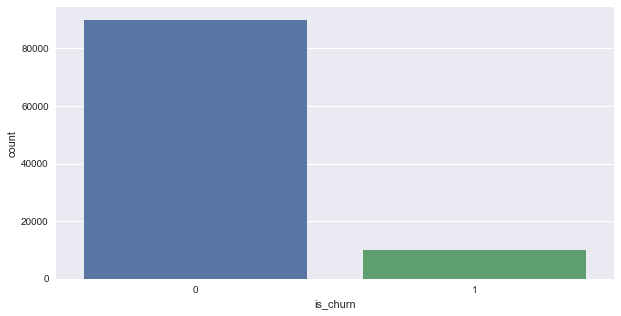

In [7]:
plt.figure(figsize=[10,5])
sns.countplot(df['is_churn'] )

For the `date`, `membership_expire_date`, `registration_init_time` and `transaction_date`, they need to be converted to datetime objects. 

In [8]:
df['date'] = df.date.apply(lambda x: datetime.strptime(str(int(x)), '%Y%m%d').date() if pd.notnull(x) else np.nan)
df['membership_expire_date'] = df['membership_expire_date'].apply(lambda x: datetime.strptime(str(int(x)), '%Y%m%d').date() if pd.notnull(x) else np.nan)
df['registration_init_time'] = df['registration_init_time'].apply(lambda x: datetime.strptime(str(int(x)), '%Y%m%d').date() if pd.notnull(x) else np.nan)
df['transaction_date'] = df['transaction_date'].apply(lambda x: datetime.strptime(str(int(x)), '%Y%m%d').date() if pd.notnull(x) else np.nan)

In [568]:
df[['date','transaction_date','registration_init_time','membership_expire_date', 'is_churn']].sample(100)

,date,transaction_date,registration_init_time,membership_expire_date,is_churn
71070,2017-03-31,2017-03-11,2010-09-22,2017-04-11,0
3442,2017-03-12,2017-03-31,2008-02-07,2017-04-30,0
40283,2017-03-17,2017-02-28,2008-01-07,2017-04-28,0
3967,2017-03-15,2017-03-16,2013-01-17,2017-04-16,0
47762,2017-03-14,2017-03-31,2014-01-30,2017-05-07,0
24740,2017-03-04,2017-03-29,2011-02-25,2017-09-30,1
67114,2017-03-30,2017-03-17,2016-10-18,2017-04-17,0
69462,2017-03-11,2017-03-26,2010-11-11,2017-04-28,0
12802,2017-03-26,2017-03-21,2017-01-14,2017-04-20,0
92715,2017-03-13,2017-03-29,2013-02-07,2017-04-28,0


`bd` represents the age of subscribers. However, the `max` and `min` do not make sense.

In [10]:
df['bd'].describe()

count    99302.000000
mean        15.665123
std         18.613675
min       -178.000000
25%          0.000000
50%         19.000000
75%         28.000000
max       1034.000000
Name: bd, dtype: float64

Hence, I have reserved all the values within the range from 0 to 99. Others will be replaced by the median of the column, since the median is not as sensitive to the outliers as the mean.

In [12]:
df['bd'] = df['bd'].apply(lambda x: int(x) if x > 0 and x < 100 else int(df['bd'].median()))

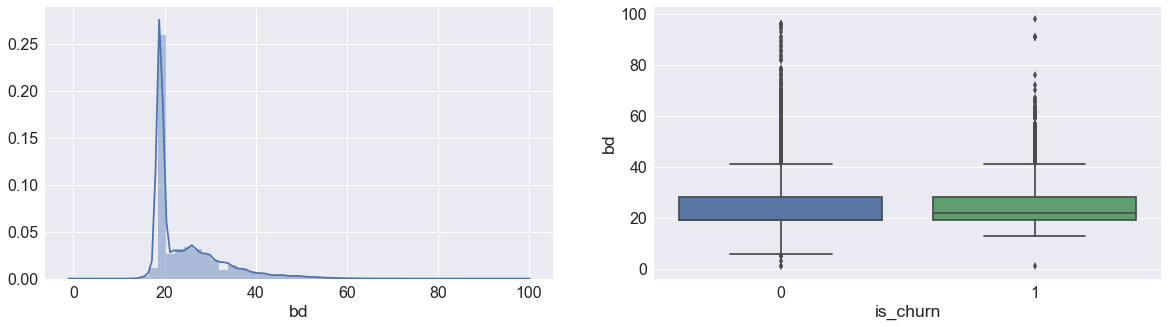

In [13]:
sns.set(font_scale=1.6)
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.distplot(df['bd'],kde=True, ax=ax1)
sns.boxplot(x= df['is_churn'], y=df['bd'], ax=ax2)

It seems that there are numerous outliers, but it does not make sense to drop those outliers on the right since it is possible for people aged 40+ to subscribe the service.

`City` is a variable consisting of values ranging from `1` to `22`. Each value represents a city, but we don't know which city each number is representing. For the purpose of EDA, the missing values have been replaced by a string - `NAN`. 

In [14]:
df['city'] = df['city'].apply(lambda x: int(x) if pd.notnull(x) else 'NAN')

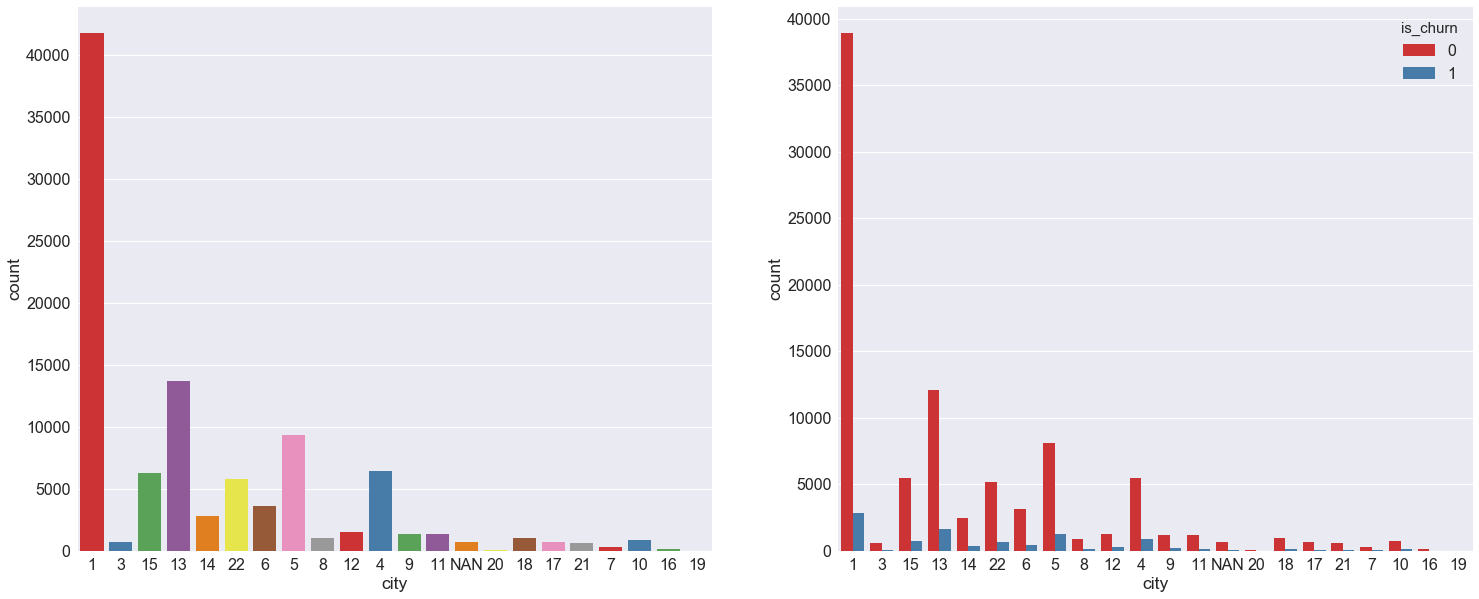

In [15]:
sns.set(font_scale=1.6)
fig = plt.figure(figsize=[25,10])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.countplot(x=df['city'], palette="Set1", ax=ax1)
sns.countplot(x=df['city'], hue=df['is_churn'], palette="Set1", ax=ax2)

For the missing values in `Gender`, they are converted to `NAN` as well.

In [16]:
df['gender'] = df['gender'].apply(lambda x: x if pd.notnull(x) else 'NAN')

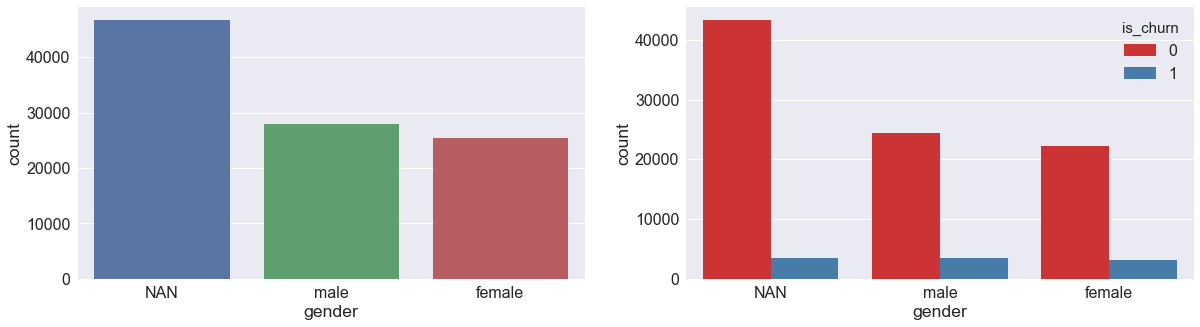

In [17]:
sns.set(font_scale=1.6)
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.countplot(x=df.gender,  ax=ax1)
sns.countplot(x=df.gender, hue=df.is_churn, palette="Set1", ax=ax2)

The following variables are the records of each user's behavior.  

`num_25`: # of songs played less than 25% of the song length  
`num_50`: # of songs played between 25% to 50% of the song length  
`num_75`: # of songs played between 50% to 75% of of the song length  
`num_985`: # of songs played between 75% to 98.5% of the song length  
`num_100`: # of songs played over 98.5% of the song length  
`num_unq`: # of unique songs played  
`total_secs`: total seconds played  


For the missing values of above variables, they will be replaced by the median.

In [18]:
df['num_25'].fillna(df['num_25'].median(), inplace=True)
df['num_50'].fillna(df['num_50'].median(), inplace=True)
df['num_75'].fillna(df['num_75'].median(), inplace=True)
df['num_985'].fillna(df['num_985'].median(), inplace=True)
df['num_100'].fillna(df['num_100'].median(), inplace=True)
df['num_unq'].fillna(df['num_unq'].median(), inplace=True)
df['total_secs'].fillna(df['total_secs'].median(), inplace=True)

In [19]:
print(df['num_25'].isnull().sum()) 
print(df['num_50'].isnull().sum()) 
print(df['num_75'].isnull().sum()) 
print(df['num_985'].isnull().sum()) 
print(df['num_100'].isnull().sum()) 
print(df['num_unq'].isnull().sum()) 
print(df['total_secs'].isnull().sum())

0
0
0
0
0
0
0


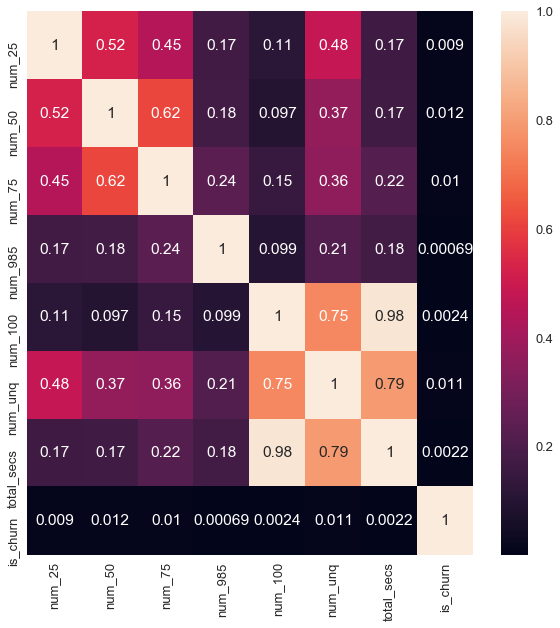

In [542]:
plt.figure(figsize=[10,10])
sns.heatmap(df[['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs','is_churn']].corr(), annot=True)

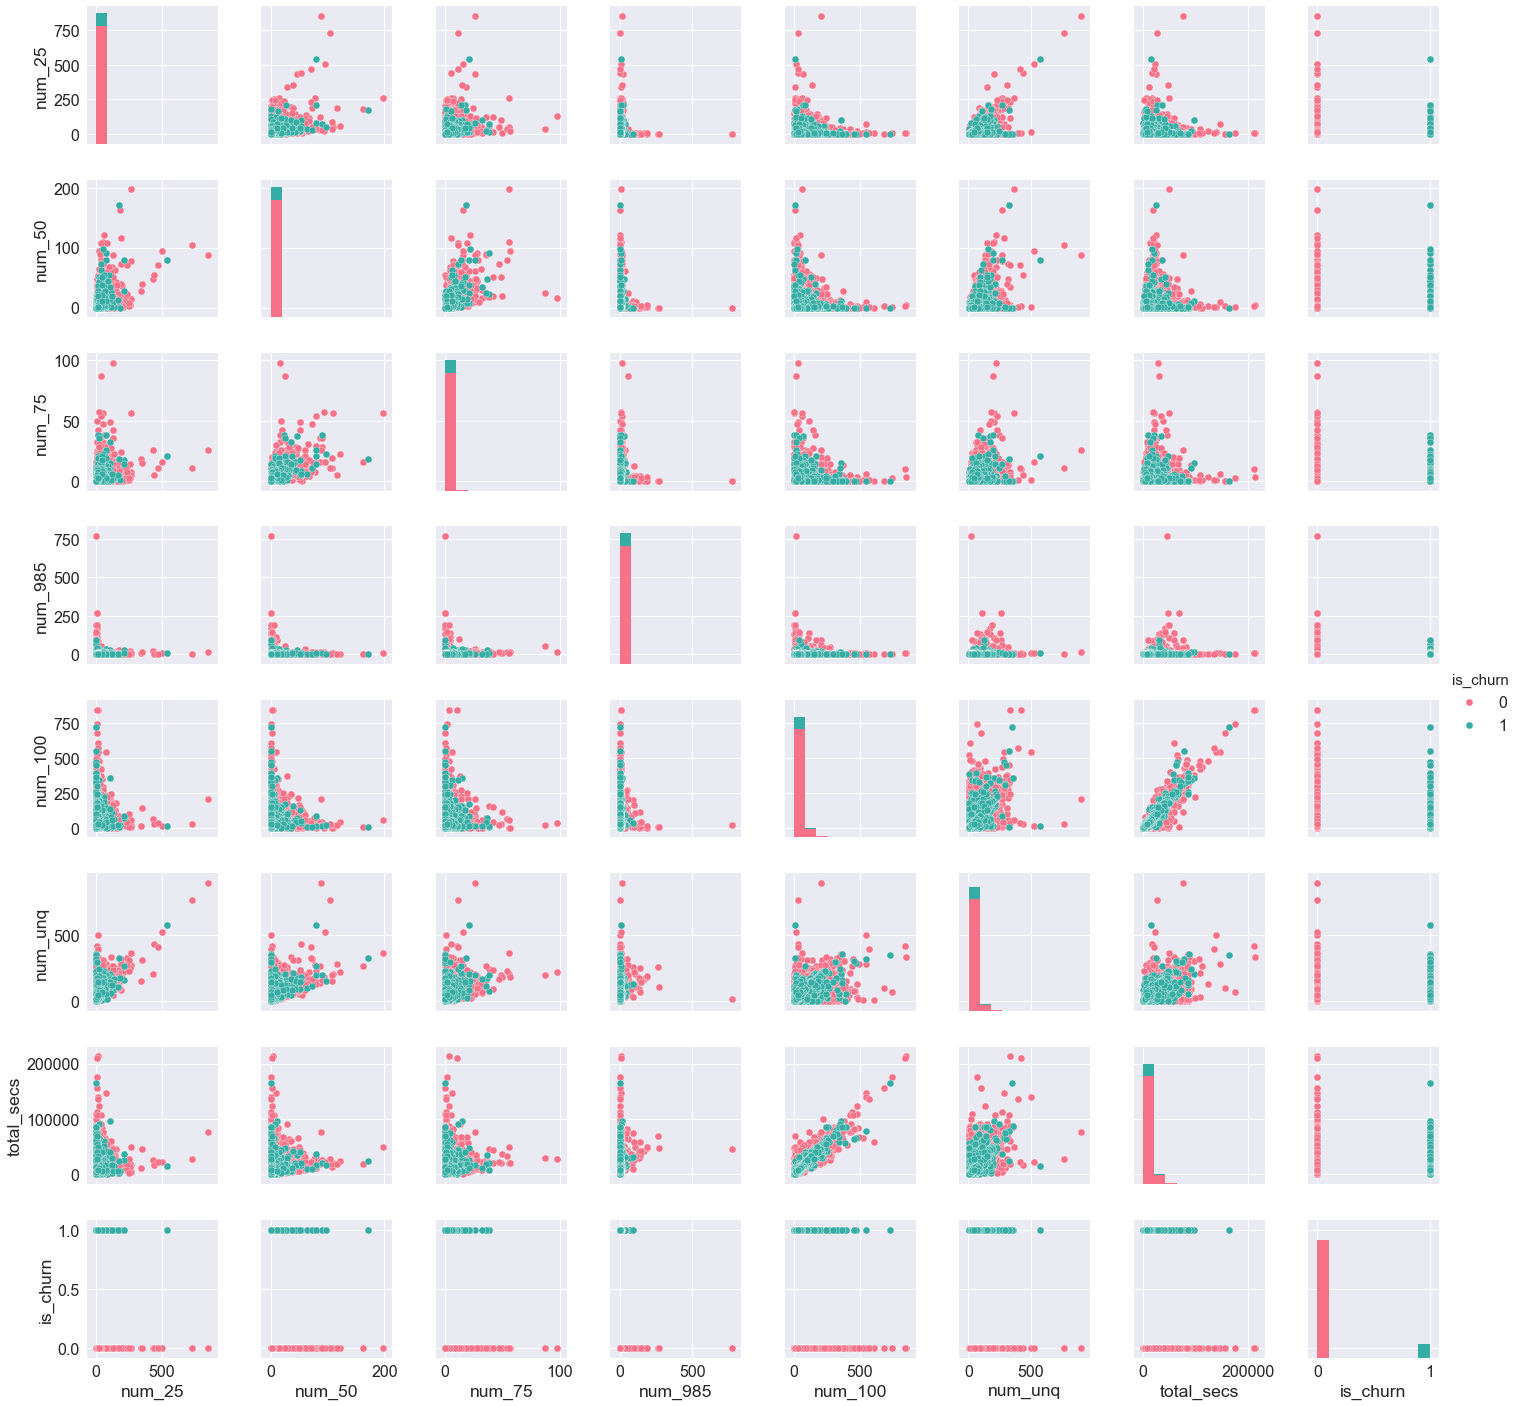

In [21]:
nums = df[['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs','is_churn']]
sns.pairplot(nums, hue='is_churn', palette="husl")

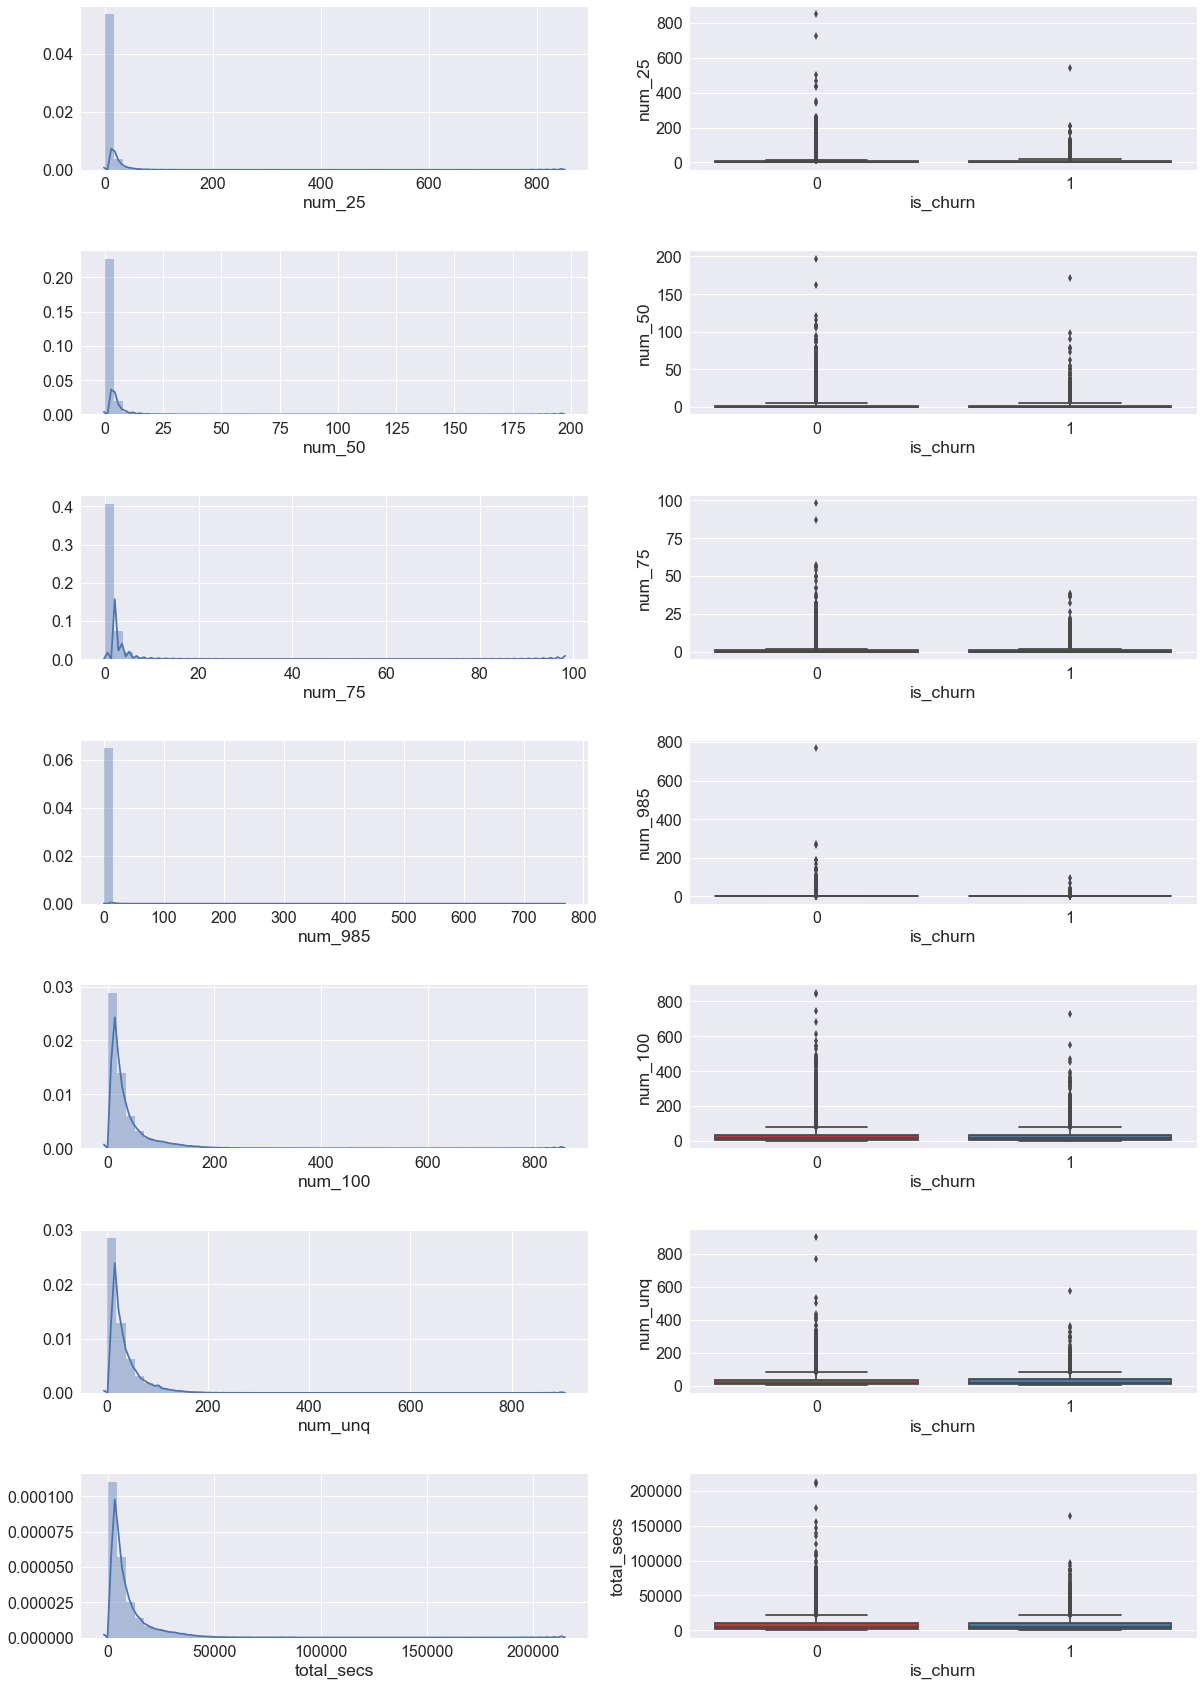

In [24]:
fig = plt.figure(figsize=[20,30])
ax1 = fig.add_subplot(7,2,1)
ax2 = fig.add_subplot(7,2,2)
ax3 = fig.add_subplot(7,2,3)
ax4 = fig.add_subplot(7,2,4)
ax5 = fig.add_subplot(7,2,5)
ax6 = fig.add_subplot(7,2,6)
ax7 = fig.add_subplot(7,2,7)
ax8 = fig.add_subplot(7,2,8)
ax9 = fig.add_subplot(7,2,9)
ax10 = fig.add_subplot(7,2,10)
ax11 = fig.add_subplot(7,2,11)
ax12 = fig.add_subplot(7,2,12)
ax13 = fig.add_subplot(7,2,13)
ax14 = fig.add_subplot(7,2,14)

sns.distplot(df.num_25, kde=True, ax=ax1)
sns.boxplot(x= df['is_churn'], y=df.num_25, ax=ax2, palette='Set1')

sns.distplot(df.num_50, kde=True, ax=ax3)
sns.boxplot(x= df['is_churn'], y=df.num_50, ax=ax4, palette='Set1')

sns.distplot(df.num_75, kde=True, ax=ax5)
sns.boxplot(x= df['is_churn'], y=df.num_75, ax=ax6, palette='Set1')

sns.distplot(df.num_985, kde=True, ax=ax7)
sns.boxplot(x= df['is_churn'], y=df.num_985, ax=ax8, palette='Set1')

sns.distplot(df.num_100, kde=True, ax=ax9)
sns.boxplot(x= df['is_churn'], y=df.num_100, ax=ax10, palette='Set1')

sns.distplot(df.num_unq, kde=True, ax=ax11)
sns.boxplot(x= df['is_churn'], y=df.num_unq, ax=ax12, palette='Set1')

sns.distplot(df.total_secs, kde=True, ax=ax13)
sns.boxplot(x= df['is_churn'], y=df.total_secs, ax=ax14, palette='Set1')


plt.subplots_adjust(hspace=0.5)
sns.set(font_scale=1.5)

The following variables are categorical, so the missing values will be replaced by `NAN` for the purpose of EDA.  

In [25]:
df['registered_via'].fillna('NAN' ,inplace=True) # the method you adopted for registration
df['is_auto_renew'].fillna('NAN' ,inplace=True) # whehter you adopted auto renewal 0 = Yes
df['is_cancel'].fillna('NAN' ,inplace=True) # whether you actively cancels a subscription 0 = Yes
df['payment_method_id'].fillna('NAN' ,inplace=True) # the method you adopted for payment

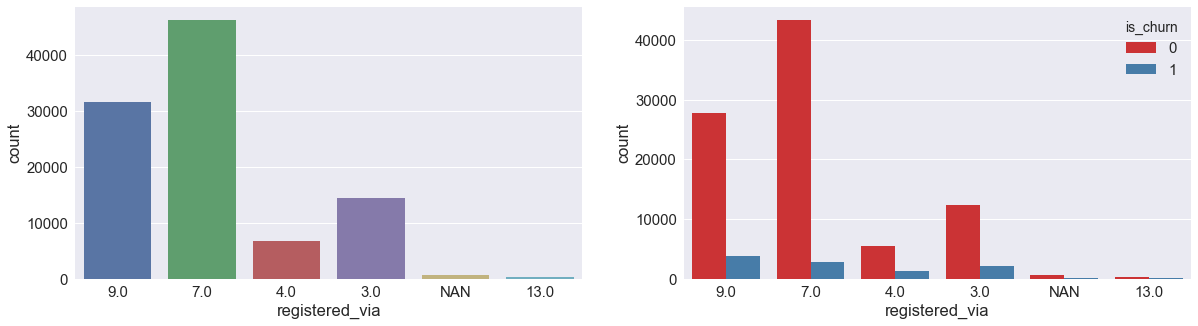

In [26]:
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.countplot(df.registered_via, ax=ax1)
sns.countplot(df.registered_via, ax=ax2, hue=df['is_churn'], palette='Set1')
sns.set(font_scale=1.5)
plt.subplots_adjust(wspace=0.2)

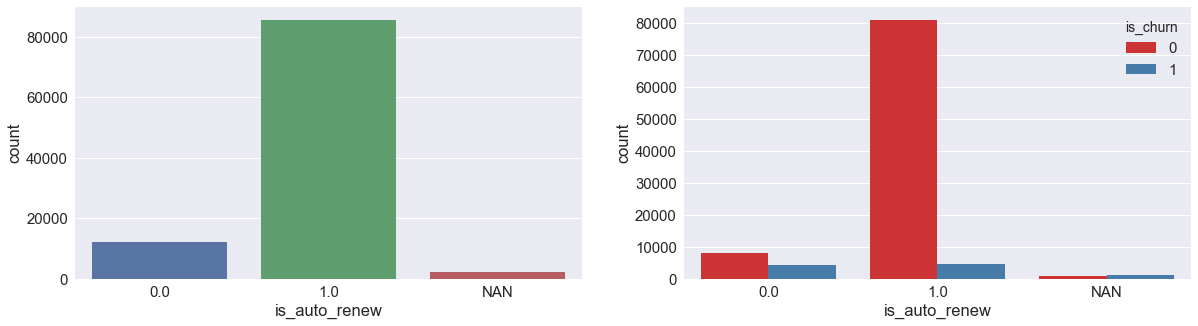

In [27]:
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.countplot(df['is_auto_renew'], ax=ax1)
sns.countplot(df['is_auto_renew'], ax=ax2, hue=df['is_churn'], palette='Set1')
sns.set(font_scale=1.5)
plt.subplots_adjust(wspace=0.2)

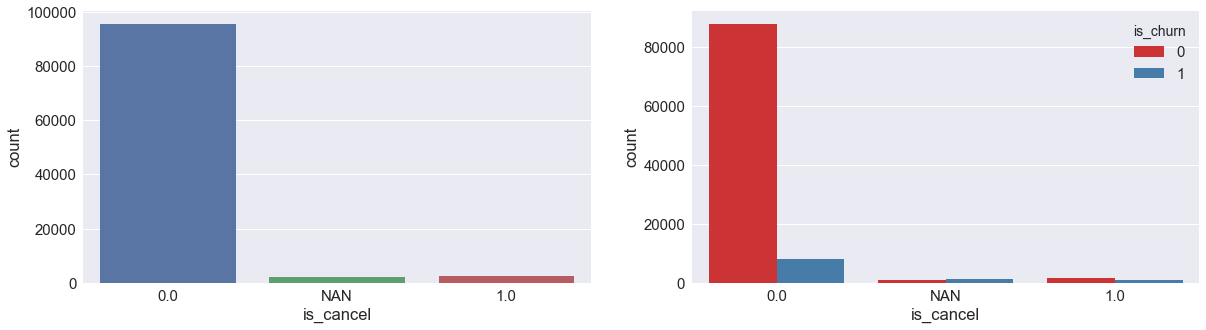

In [28]:
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.countplot(df['is_cancel'], ax=ax1)
sns.countplot(df['is_cancel'], ax=ax2, hue=df['is_churn'], palette='Set1')
sns.set(font_scale=1.5)
plt.subplots_adjust(wspace=0.2)

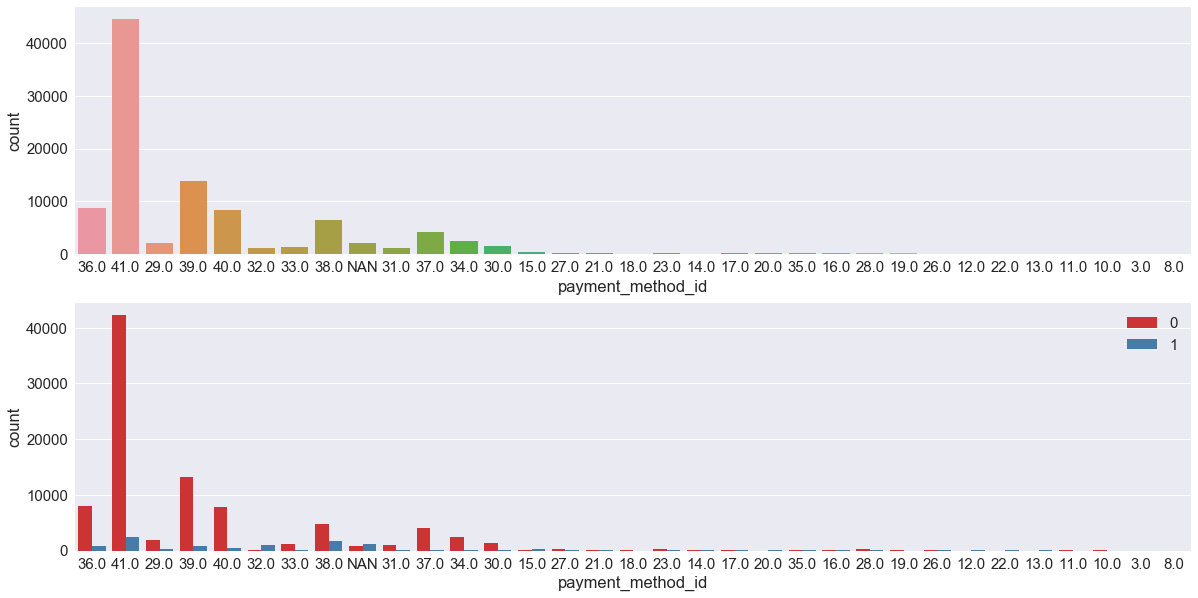

In [29]:
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
sns.countplot(df['payment_method_id'], ax=ax1)
sns.countplot(df['payment_method_id'], ax=ax2, hue=df['is_churn'], palette='Set1')
sns.set(font_scale=1.5)
plt.subplots_adjust(wspace=0.2)
plt.legend(loc='upper right')

`payment_plan_days`: length of membership plan in days  

In [30]:
payplan_median = df['payment_plan_days'].median()
df['payment_plan_days'] = df['payment_plan_days'].apply(lambda x: int(x) if pd.notnull(x) else payplan_median)

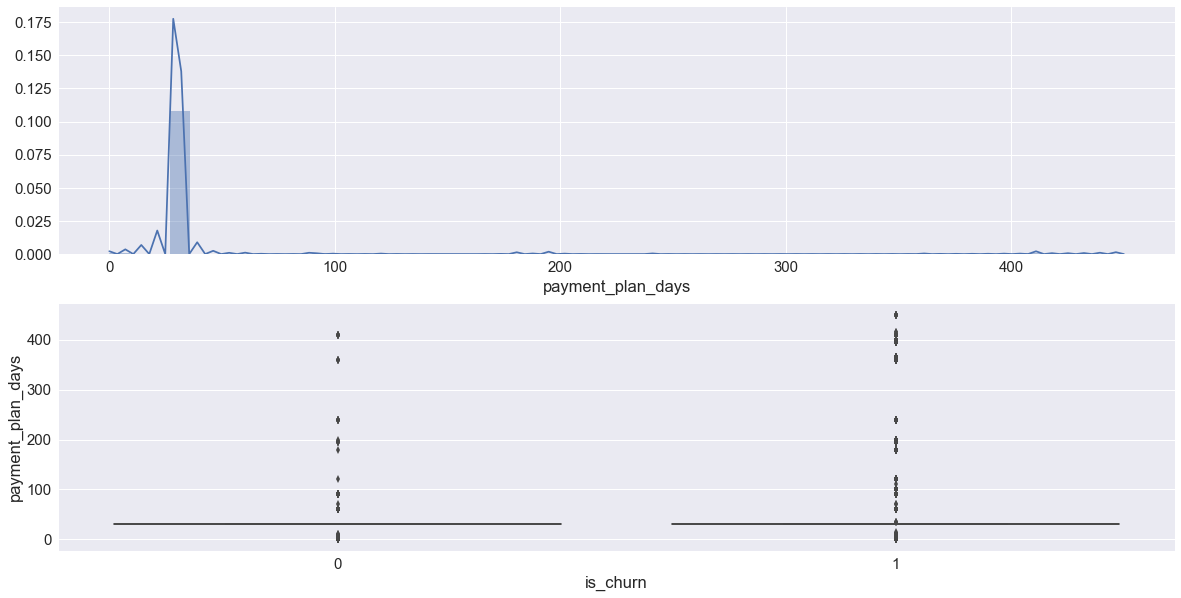

In [31]:
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
sns.distplot(df['payment_plan_days'], ax=ax1)
sns.boxplot(y=df['payment_plan_days'], ax=ax2, x=df['is_churn'], palette='Set1')
sns.set(font_scale=1.5)
plt.subplots_adjust(wspace=0.2)

In [32]:
df['plan_list_price'].fillna(df['plan_list_price'].median(), inplace=True)
df['actual_amount_paid'].fillna(df['actual_amount_paid'].median(), inplace=True)

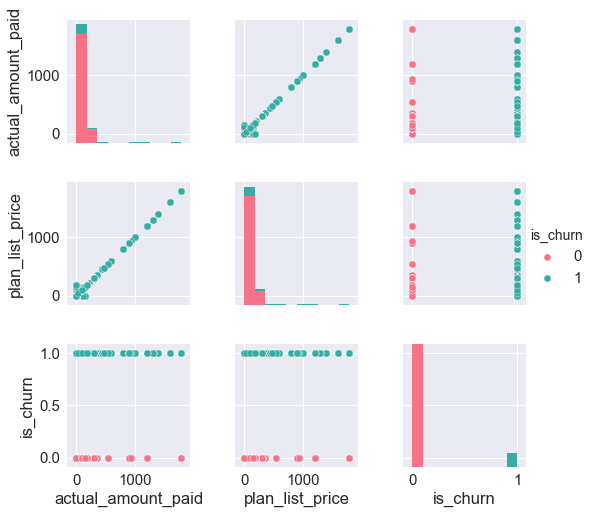

In [33]:
price = df[['actual_amount_paid','plan_list_price','is_churn']]
sns.pairplot(price, hue='is_churn', palette="husl")

## 4. Predict what's likely to happen

### 4.1 Data Prepossessing

After EDA, all missing values in each column should be unified as np.nan for the purpose of modelling, except for `gender`. (Transgender people never agree to this male-female binary classification)

In [34]:
df['is_auto_renew'] = [np.nan if value == 'NAN' else value for value in df.is_auto_renew]
df['registered_via'] = [np.nan if value == 'NAN' else value for value in df.registered_via]
df['is_cancel'] = [np.nan if value == 'NAN' else value for value in df.is_cancel]
df['payment_method_id'] = [np.nan if value == 'NAN' else value for value in df.payment_method_id]
df['city'] = [np.nan if value == 'NAN' else value for value in df.city]
df['city'] = df['city'].astype('str')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
msno                      100000 non-null object
is_churn                  100000 non-null int64
city                      100000 non-null object
bd                        100000 non-null int64
gender                    100000 non-null object
registered_via            99302 non-null float64
registration_init_time    99302 non-null object
payment_method_id         97987 non-null float64
payment_plan_days         100000 non-null float64
plan_list_price           100000 non-null float64
actual_amount_paid        100000 non-null float64
is_auto_renew             97987 non-null float64
transaction_date          97987 non-null object
membership_expire_date    97987 non-null object
is_cancel                 97987 non-null float64
date                      98512 non-null object
num_25                    100000 non-null float64
num_50                    100000 non-null float64
num_75   

In [36]:
kkbox_ml = df.drop(columns=['registration_init_time','transaction_date','membership_expire_date','date','msno'])

In [37]:
kkbox_ml.dropna(inplace=True)

In [38]:
kkbox_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97299 entries, 0 to 99999
Data columns (total 18 columns):
is_churn              97299 non-null int64
city                  97299 non-null object
bd                    97299 non-null int64
gender                97299 non-null object
registered_via        97299 non-null float64
payment_method_id     97299 non-null float64
payment_plan_days     97299 non-null float64
plan_list_price       97299 non-null float64
actual_amount_paid    97299 non-null float64
is_auto_renew         97299 non-null float64
is_cancel             97299 non-null float64
num_25                97299 non-null float64
num_50                97299 non-null float64
num_75                97299 non-null float64
num_985               97299 non-null float64
num_100               97299 non-null float64
num_unq               97299 non-null float64
total_secs            97299 non-null float64
dtypes: float64(14), int64(2), object(2)
memory usage: 14.1+ MB


After dealing with the missing values, we need to take care of the categorical variables (`city`, `gender`, `registered_via`, `payment_method_id`, `is_churn`, `is_cancel`, `is_auto_renew`) by using pd.get_dummies. 

In [39]:
city = pd.get_dummies(kkbox_ml.city, prefix='city')
gender = pd.get_dummies(kkbox_ml.gender, prefix='gender')
reg_method = pd.get_dummies(kkbox_ml.registered_via, prefix='reg_method')
pay_method = pd.get_dummies(kkbox_ml.payment_method_id, prefix='pay_method')
churn = pd.get_dummies(kkbox_ml.is_churn, prefix='is_churn')
cancel = pd.get_dummies(kkbox_ml.is_cancel, prefix='is_cancel')
autorenew = pd.get_dummies(kkbox_ml.is_auto_renew, prefix='is_auto_renew')

In [40]:
numerics = kkbox_ml[['actual_amount_paid','plan_list_price','payment_plan_days', 'bd',
                   'num_25','num_50','num_75','num_985','num_100','num_unq','total_secs']]

numerics.tail(5)

,actual_amount_paid,plan_list_price,payment_plan_days,bd,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
99995,149.0,149.0,30.0,34,6.0,2.0,1.0,1.0,46.0,44.0,10954.243
99996,180.0,180.0,30.0,25,1.0,1.0,0.0,1.0,13.0,16.0,3743.362
99997,149.0,149.0,30.0,26,8.0,0.0,0.0,1.0,9.0,14.0,2863.536
99998,149.0,149.0,30.0,19,10.0,0.0,2.0,1.0,28.0,39.0,6915.438
99999,149.0,149.0,30.0,19,19.0,2.0,0.0,2.0,29.0,49.0,7336.248


In [41]:
catergoricals = pd.concat([city, gender, reg_method, pay_method, churn, cancel, autorenew], axis=1)

In [42]:
catergoricals.drop(columns=['is_churn_0','is_cancel_0.0', 'is_auto_renew_0.0'], inplace=True)
catergoricals.tail(5)

,city_1.0,city_10.0,city_11.0,city_12.0,city_13.0,city_14.0,city_15.0,city_16.0,city_17.0,city_18.0,...,pay_method_35.0,pay_method_36.0,pay_method_37.0,pay_method_38.0,pay_method_39.0,pay_method_40.0,pay_method_41.0,is_churn_1,is_cancel_1.0,is_auto_renew_1.0
99995,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99996,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
99997,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
99998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
99999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [43]:
kk_ml_df = pd.concat([numerics, catergoricals], axis = 1)

In [44]:
kk_ml_df.tail(5)

,actual_amount_paid,plan_list_price,payment_plan_days,bd,num_25,num_50,num_75,num_985,num_100,num_unq,...,pay_method_35.0,pay_method_36.0,pay_method_37.0,pay_method_38.0,pay_method_39.0,pay_method_40.0,pay_method_41.0,is_churn_1,is_cancel_1.0,is_auto_renew_1.0
99995,149.0,149.0,30.0,34,6.0,2.0,1.0,1.0,46.0,44.0,...,0,0,0,0,0,0,1,0,0,1
99996,180.0,180.0,30.0,25,1.0,1.0,0.0,1.0,13.0,16.0,...,0,1,0,0,0,0,0,0,0,0
99997,149.0,149.0,30.0,26,8.0,0.0,0.0,1.0,9.0,14.0,...,0,0,0,0,1,0,0,0,0,1
99998,149.0,149.0,30.0,19,10.0,0.0,2.0,1.0,28.0,39.0,...,0,0,0,1,0,0,0,0,0,0
99999,149.0,149.0,30.0,19,19.0,2.0,0.0,2.0,29.0,49.0,...,0,0,0,0,1,0,0,0,0,1


In [45]:
kk_ml_df.to_csv('kk_ml_df.csv')

In [46]:
kk_ml_df = pd.DataFrame(pd.read_csv('kk_ml_df.csv'))

In [49]:
kk_ml_df.drop(columns=['Unnamed: 0'], inplace=True)

### 4.2 Split the data

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X = kk_ml_df.drop(columns=['is_churn_1'])
y = kk_ml_df['is_churn_1']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.2)

In [52]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(77839, 74)
(77839,)
(19460, 74)
(19460,)


### 4.3 Import Algorithms, Pipeline, StandardScaler, GridSearchCV and  Metrics

In [166]:
import sklearn

# Import Algorithms 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Pipeline creator
from sklearn.pipeline import make_pipeline

# Standardisation
from sklearn.preprocessing import StandardScaler

# GridSearch
from sklearn.model_selection import GridSearchCV

# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

In this task, I have selected  random forest classifer, gradient boosting classifer and XgBoost Classifier for modeling. 

In [89]:
pipelines = {
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123)),
    'xgb': make_pipeline(StandardScaler(), XGBClassifier(random_state=123))
}

In [93]:
rf_hyperparameters = {'randomforestclassifier__n_estimators':100}
gb_hyperparameters = {'gradientboostingclassifier__n_estimators':100}
xgb_hyperparameters= {'xgbclassifier__n_estimators': 100 }

In [95]:
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'xgb': xgb_hyperparameters
}

`GridSearchCV` was adopted for cross validation.

In [96]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted.')

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


rf has been fitted.


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


gb has been fitted.


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


xgb has been fitted.


`model.best_score_`: Mean cross-validated score of the best_estimator  
`xgb` performs the best.

In [97]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

rf 0.9388352882231272
gb 0.9397088862909339
xgb 0.9397602744125695


In [546]:
for name, model in fitted_models.items():
    print(name, accuracy_score(y_test, model.predict(X_test)))

/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


rf 0.9404933196300103
gb 0.9413669064748201


/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


xgb 0.9414696813977389


### 4.41 Feature Importance: Random Forest Classifier

Text(0.5,0,'Relative Frequency')

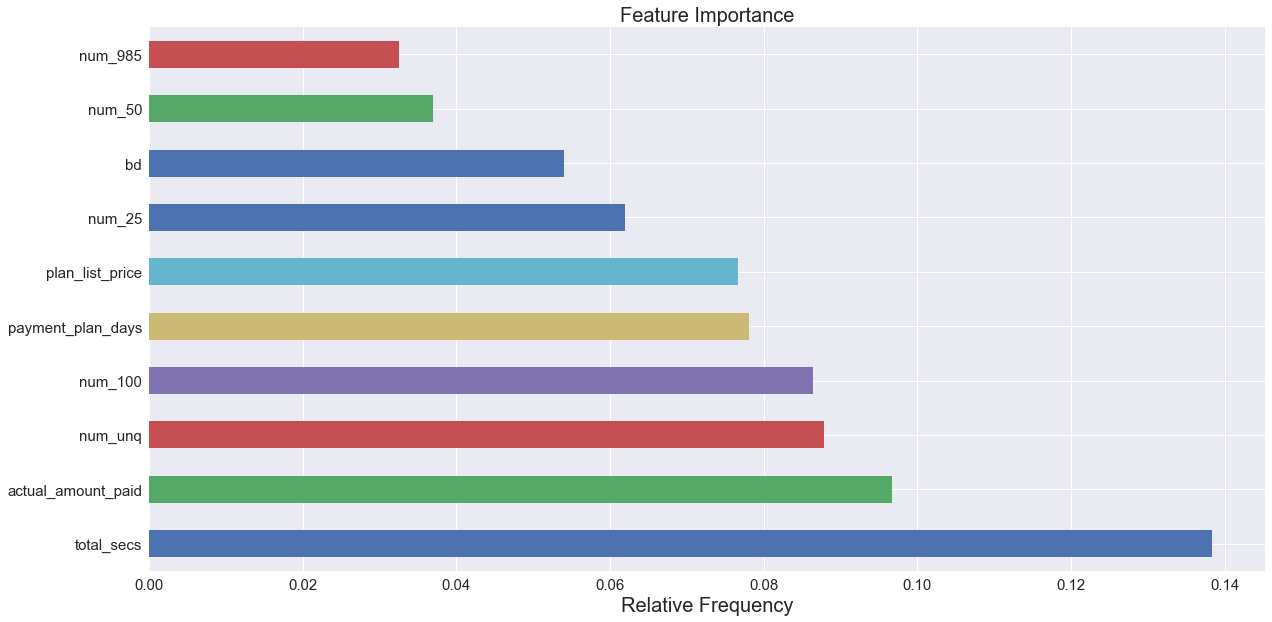

In [485]:
importances = fitted_models['rf'].best_estimator_.steps[1][1].feature_importances_
features = X_train.columns
plt.figure(figsize=[20,10])
feat_importances = pd.Series(importances, index=features)
feat_importances.nlargest(10).plot(kind='barh', fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Relative Frequency', fontsize=20)

### 4.42 Feature Importance: XGBoost Classifier

Text(0.5,0,'Relative Frequency')

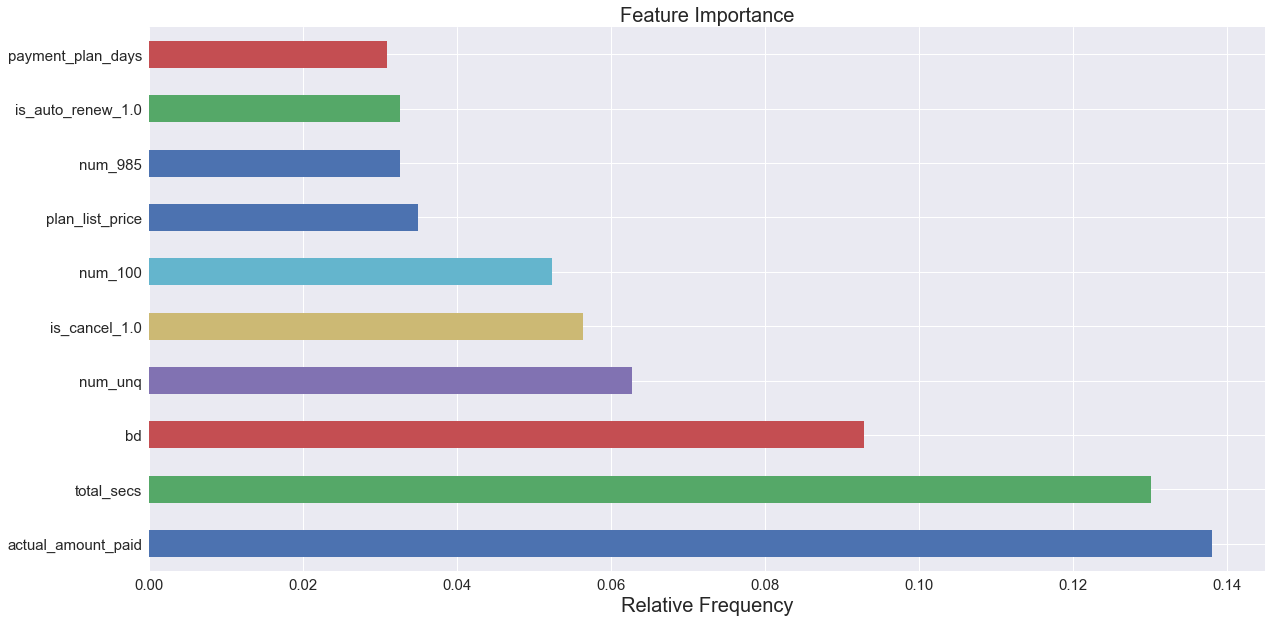

In [484]:
importances = fitted_models['xgb'].best_estimator_.steps[1][1].feature_importances_
features = X_train.columns
plt.figure(figsize=[20,10])
feat_importances = pd.Series(importances, index=features)
feat_importances.nlargest(10).plot(kind='barh', fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Relative Frequency', fontsize=20)

### 4.43 Feature Importance: Gradient Boosting Classifier

Text(0.5,0,'Relative Frequency')

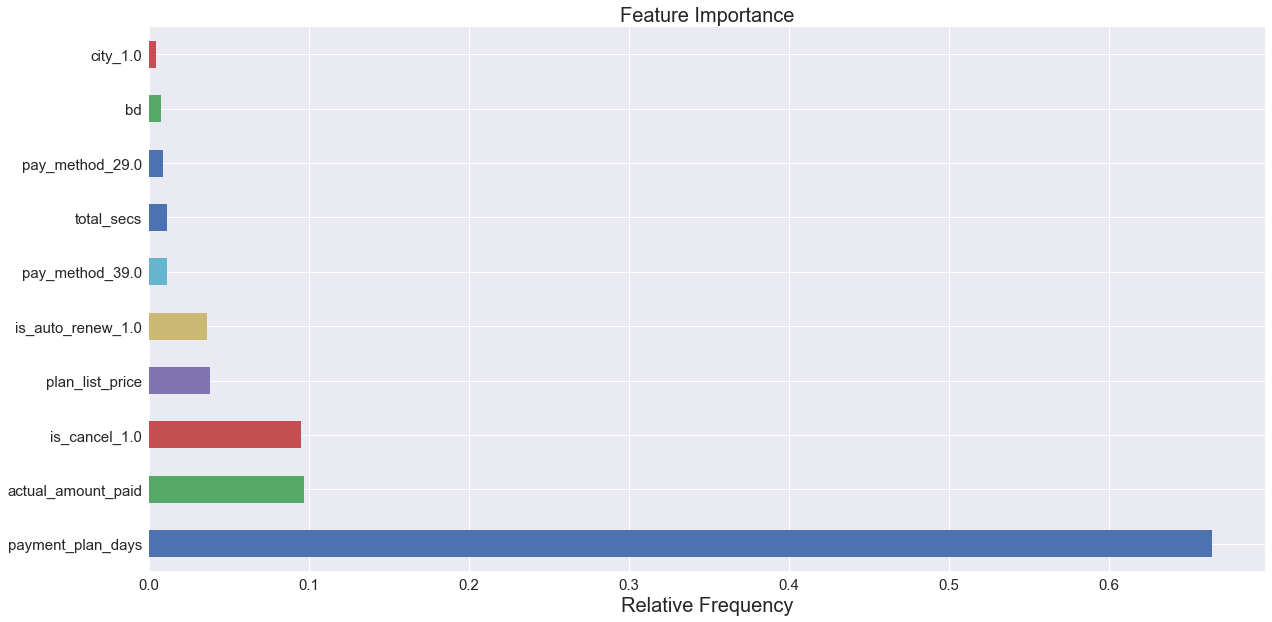

In [483]:
importances = fitted_models['gb'].best_estimator_.steps[1][1].feature_importances_
features = X_train.columns
plt.figure(figsize=[20,10])
feat_importances = pd.Series(importances, index=features)
feat_importances.nlargest(10).plot(kind='barh', fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Relative Frequency', fontsize=20)

### 4.5 Feature Selection

Use the features according to the Feature Importance of each algorithm by importing `SelectFromModel`.  

For each algorithm, I have created new `select_X_train_[algo_name]` and `select_X_test_[algo_name]` for another round of modeling.

In [559]:
from sklearn.feature_selection import SelectFromModel

thresholds = {}

for name in fitted_models:
    thresholds.update({name:fitted_models[name].best_estimator_.steps[1][1].feature_importances_})
    
    
for thresh in thresholds['gb']:
    selection_gb = SelectFromModel(fitted_models['gb'].best_estimator_.steps[1][1], threshold=np.median(thresholds['gb']), prefit=True)
    select_X_train_gb = selection_gb.transform(X_train)
    select_X_test_gb = selection_gb.transform(X_test)
    

for thresh in thresholds['rf']:
    selection_rf = SelectFromModel(fitted_models['rf'].best_estimator_.steps[1][1], threshold=np.median(thresholds['rf']), prefit=True)
    select_X_train_rf = selection_rf.transform(X_train) 
    select_X_test_rf = selection_rf.transform(X_test)
    

for thresh in thresholds['xgb']:
    selection_xgb = SelectFromModel(fitted_models['xgb'].best_estimator_.steps[1][1], threshold=np.median(thresholds['xgb']), prefit=True)
    select_X_train_xgb = selection_xgb.transform(X_train)
    select_X_test_xgb = selection_xgb.transform(X_test)

After transforming the `X_train` and `X_test` and getting the new stuff, we can train the model again. But this time, we will use the features selected by each algo instead.

In [561]:
pipelines = {
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=100)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=100)),
    'xgb': make_pipeline(StandardScaler(), XGBClassifier(random_state=100))
}

rf_hyperparameters = {'randomforestclassifier__n_estimators': [100, 200]}
gb_hyperparameters = {'gradientboostingclassifier__n_estimators': [100, 200]}
xgb_hyperparameters= {'xgbclassifier__n_estimators': [100, 200]}

hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'xgb': xgb_hyperparameters
}


new_fitted_models = {}

rf_cv = GridSearchCV(pipelines['rf'], hyperparameters['rf'], cv=5, n_jobs=-1)
rf_cv.fit(select_X_train_rf, y_train)
new_fitted_models['rf'] = rf_cv

gb_cv = GridSearchCV(pipelines['gb'], hyperparameters['gb'], cv=5, n_jobs=-1)
gb_cv.fit(select_X_train_gb, y_train)
new_fitted_models['gb'] = gb_cv

xgb_cv = GridSearchCV(pipelines['xgb'], hyperparameters['xgb'], cv=5, n_jobs=-1)
xgb_cv.fit(select_X_train_xgb, y_train)
new_fitted_models['xgb'] = xgb_cv

## 5. Evaluation

### `Accuracy`: Overall, how often are the classifiers correct?

In [562]:
b4_rf_pred = fitted_models['rf'].predict(X_test)
b4_gb_pred = fitted_models['gb'].predict(X_test)
b4_xgb_pred = fitted_models['xgb'].predict(X_test)

print('Before feature selection:\n')
print('rf ', accuracy_score(y_test, b4_rf_pred))
print('gb ', accuracy_score(y_test, b4_gb_pred))
print('xgb ', accuracy_score(y_test, b4_xgb_pred))
  
after_rf_pred = new_fitted_models['rf'].predict(select_X_test_rf)
after_gb_pred = new_fitted_models['gb'].predict(select_X_test_gb)
after_xgb_pred = new_fitted_models['xgb'].predict(select_X_test_xgb)

print('\n After feature selection:\n')
print('rf ', accuracy_score(y_test, after_rf_pred))
print('gb ', accuracy_score(y_test, after_gb_pred))
print('xgb ', accuracy_score(y_test, after_xgb_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Before feature selection:

rf  0.9404933196300103
gb  0.9413669064748201
xgb  0.9414696813977389

 After feature selection:

rf  0.9398766700924974
gb  0.9412641315519014
xgb  0.9411613566289825


### `Precision`: When a positive value is predicted, how often is the prediction correct?
###  `Recall`:  When the actual value is positive, how often is the prediction correct?  

In [563]:
from sklearn.metrics import classification_report

print('                     BEFORE FEATURE SELECTION: GB \n')
print(classification_report(y_test, b4_gb_pred))
print('\n')

print('                     AFTER FEATURE SELECTION: GB \n')
print(classification_report(y_test, after_gb_pred ))
print('\n')

print('                     BEFORE FEATURE SELECTION: RF \n')
print(classification_report(y_test, b4_rf_pred))
print('\n')

print('                     AFTER FEATURE SELECTION: RF \n')
print(classification_report(y_test, after_rf_pred))
print('\n')

print('                     BEFORE FEATURE SELECTION: XGB \n')
print(classification_report(y_test, b4_xgb_pred))

print('                     AFTER FEATURE SELECTION: XGB \n')
print(classification_report(y_test, after_xgb_pred))

                     BEFORE FEATURE SELECTION: GB 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     17717
           1       0.92      0.38      0.54      1743

   micro avg       0.94      0.94      0.94     19460
   macro avg       0.93      0.69      0.75     19460
weighted avg       0.94      0.94      0.93     19460



                     AFTER FEATURE SELECTION: GB 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     17717
           1       0.91      0.38      0.54      1743

   micro avg       0.94      0.94      0.94     19460
   macro avg       0.93      0.69      0.75     19460
weighted avg       0.94      0.94      0.93     19460



                     BEFORE FEATURE SELECTION: RF 

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     17717
           1       0.85      0.41      0.55      1743

   micro avg       0.94

To evaluate the models, we can compare the `ROC Curves` of all models before and after feature selection.

/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


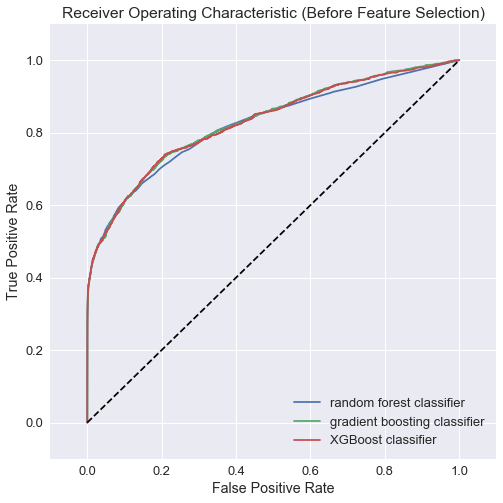

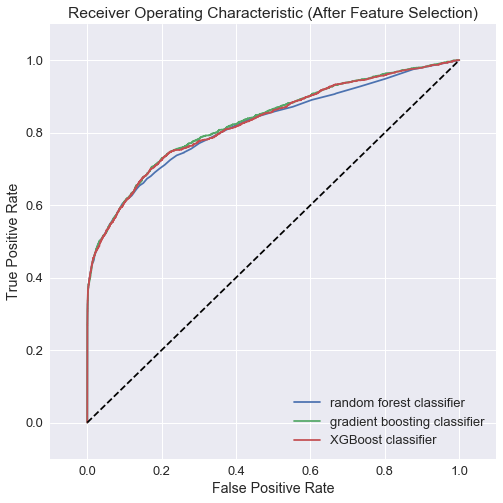

In [564]:
rf_pred = [p[1] for p in fitted_models['rf'].predict_proba(X_test)]
gb_pred = [p[1] for p in fitted_models['gb'].predict_proba(X_test)]
xgb_pred = [p[1] for p in fitted_models['xgb'].predict_proba(X_test)]

rfpr, rtpr, rthresholds = roc_curve(y_test, rf_pred)
gfpr, gtpr, gthresholds = roc_curve(y_test, gb_pred)
xgfpr, xgtpr, xgthresholds = roc_curve(y_test, xgb_pred)

fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic (Before Feature Selection)')

# Plot ROC curve of Random Forest Classifier
plt.plot(rfpr, rtpr, label='random forest classifier')
plt.legend(loc='lower right')

# Plot ROC curve of Grandient Boosting Classifier
plt.plot(gfpr, gtpr, label='gradient boosting classifier')
plt.legend(loc='lower right')

# Plot ROC curve of Grandient Boosting Classifier
plt.plot(xgfpr, xgtpr, label='XGBoost classifier')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

rf_pred = [p[1] for p in new_fitted_models['rf'].predict_proba(select_X_test_rf)]
gb_pred = [p[1] for p in new_fitted_models['gb'].predict_proba(select_X_test_gb)]
xgb_pred = [p[1] for p in new_fitted_models['xgb'].predict_proba(select_X_test_xgb)]

rfpr, rtpr, rthresholds = roc_curve(y_test, rf_pred)
gfpr, gtpr, gthresholds = roc_curve(y_test, gb_pred)
xgfpr, xgtpr, xgthresholds = roc_curve(y_test, xgb_pred)

fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic (After Feature Selection)')

# Plot ROC curve of Random Forest Classifier
plt.plot(rfpr, rtpr, label='random forest classifier')
plt.legend(loc='lower right')

# Plot ROC curve of Grandient Boosting Classifier
plt.plot(gfpr, gtpr, label='gradient boosting classifier')
plt.legend(loc='lower right')

# Plot ROC curve of Grandient Boosting Classifier
plt.plot(xgfpr, xgtpr, label='XGBoost classifier')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

For AUC Score, it has the same problem.

In [565]:
b4_select_auc = {}

for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    b4_select_auc.update({name:roc_auc_score(y_test, pred)})
    
after_select_auc = {}

rf_pred = [p[1] for p in new_fitted_models['rf'].predict_proba(select_X_test_rf)]
gb_pred = [p[1] for p in new_fitted_models['gb'].predict_proba(select_X_test_gb)]
xgb_pred = [p[1] for p in new_fitted_models['xgb'].predict_proba(select_X_test_xgb)] 

after_select_auc.update({'rf':roc_auc_score(y_test, rf_pred), 
                         'gb':roc_auc_score(y_test, gb_pred), 
                         'xgb':roc_auc_score(y_test, xgb_pred)})

/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [566]:
b4_select_auc

{'gb': 0.8307115042062962, 'rf': 0.8240285989343971, 'xgb': 0.8295356414976056}

In [567]:
after_select_auc

{'gb': 0.8314954234729741, 'rf': 0.8214681997003244, 'xgb': 0.8286823909706024}

## 6. Conclusion 

highest auc: `gb` in `after_select_auc`  
highest accuracy score: `xgb` in `b4_select_auc`   